In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
#export
from exp.nb_05b import *
torch.set_num_threads(2)

## ConvNet

[Jump_to lesson 10 video](https://course.fast.ai/videos/?lesson=10&t=3641)

In this lesson we want to create a CUDA CNN. We start as usual reading the data and normalizing them with the helper function `normalize_to`.

In [3]:
x_train, y_train, x_valid, y_valid = get_data()

Helper function to quickly normalize with the mean and standard deviation from our training set: this function takes the `normalize` function we previously created, and applies it to both the training and the validation set in one go.

In [4]:
#export
def normalize_to(train, valid):
    m, s = train.mean(), train.std()
    return normalize(train, m, s), normalize(valid, m, s)

In [5]:
x_train, x_valid = normalize_to(x_train, x_valid)
train_ds, valid_ds = Dataset(x_train, y_train), Dataset(x_valid, y_valid)

Let's check it behaved properly.

In [6]:
x_train.mean(), x_train.std()

(tensor(3.0614e-05), tensor(1.))

We create a `DataBunch` object.

In [7]:
nh, bs = 50, 512
c = y_train.max().item()+1
loss_func = F.cross_entropy

data = DataBunch(*get_dls(train_ds, valid_ds, bs), c)

To refactor layers, it's useful to have a `Lambda` layer that can take a basic function and convert it to a layer you can put in `nn.Sequential`.

**NB**: if you use a Lambda layer with a lambda function, your model won't pickle so you won't be able to save it with PyTorch. So it's best to give a name to the function you're using inside your Lambda (like flatten below).

In [8]:
# export
class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func

    def forward(self, x):
        return self.func(x)


def flatten(x):
    return x.view(x.shape[0], -1)

This one takes the flat vector of size `bs x 784` and puts it back as a batch of images of 28 by 28 pixels:

In [9]:
def mnist_resize(x):
    return x.view(-1, 1, 28, 28)

We can now define a simple CNN. We would like ot insert `mnist_resize()` into `nn.Sequential`, but PyTorch doesn't support this by default. By creating the `Lambda` layer, we can put the data resizing in the `Sequential` list. The `forward` method of the `Lambda` layer simply applies the function passed to its `__init__` method.
It's just a convenience to use `Sequential` rather than creating a subclass of `nn.Module`.

Note that we are using `stride=2` with `padding=2`. The numbers in the comment are the resulting sizes of the activation maps.

In [10]:
def get_cnn_model(data):
    return nn.Sequential(
        Lambda(mnist_resize),  # mnist_resize() as a layer.
        nn.Conv2d(1, 8, 5, padding=2, stride=2), nn.ReLU(),  # 14
        nn.Conv2d(8, 16, 3, padding=1, stride=2), nn.ReLU(),  # 7
        nn.Conv2d(16, 32, 3, padding=1, stride=2), nn.ReLU(),  # 4
        nn.Conv2d(32, 32, 3, padding=1, stride=2), nn.ReLU(),  # 2
        nn.AdaptiveAvgPool2d(1),
        Lambda(flatten),  # flatten() as a layer.
        nn.Linear(32, data.c)
    )

**TODO** check what `AdaptiveAvgPool2d` is.

In [11]:
model = get_cnn_model(data)
print(model)

Sequential(
  (0): Lambda()
  (1): Conv2d(1, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (2): ReLU()
  (3): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (4): ReLU()
  (5): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (6): ReLU()
  (7): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (8): ReLU()
  (9): AdaptiveAvgPool2d(output_size=1)
  (10): Lambda()
  (11): Linear(in_features=32, out_features=10, bias=True)
)


Basic callbacks from the previous notebook. The use of `partial` is explained in a previous notebook, and has the result of returning callback functions.

In [12]:
cbfs = [Recorder, partial(AvgStatsCallback, accuracy)]

In [13]:
opt = optim.SGD(model.parameters(), lr=0.4)
learn = Learner(model, opt, loss_func, data)
run = Runner(cb_funcs=cbfs)

In [14]:
%time run.fit(1, learn)

train: [2.1685590625, tensor(0.2202)]
valid: [1.3909466796875, tensor(0.5310)]
CPU times: user 5.48 s, sys: 164 ms, total: 5.64 s
Wall time: 1.92 s


## CUDA

This took a long time to run, so it's time to use a GPU. We need to put two things on the GPU: 1) the model, and specifically the model parameters, and 2) the inputs to the model. How do we do it? With a Callback.
The `CudaCallback` defined below makes sure that the model the inputs and the targets are all on the same device.

[Jump_to lesson 10 video](https://course.fast.ai/videos/?lesson=10&t=3799)

In [15]:
# Somewhat more flexible way
device = torch.device('cuda', 0)

The `CudaCallback` is initialized with a device `device`, and when `begin_fit()` is called, it moves the model to the device. Moreover, at the beginning of each batch, it copies `xb` and `yb` to the device. This is possible because in the `Runner` class, the definition of `one_batch()` is the following:

```python
def one_batch(self, xb, yb):
    self.xb = xb
    self.yb = yb
    ...
```

In the callback the `begin_batch()` method is defined as follows:

```python
def begin_batch(self):
    self.run.xb = self.xb.to(device)
    self.run.yb = self.yb.to(device)
```

This function changes `xb` and `yb` in the `Runner` instance. The fact that `begin_batch()` accesses the Runner `run` is confusing to me: why do you want to reference things that never appear in the Callback definition? Doesn't this violate the orthogonality principle?.

In [16]:
class CudaCallback(Callback):
    def __init__(self, device):
        self.device = device

    def begin_fit(self):
        self.model.to(self.device)

    def begin_batch(self):
        self.run.xb = self.xb.to(self.device)
        self.run.yb = self.yb.to(self.device)

As an alternative, one can do the following, which looks much easier and understandable to me.

In [17]:
# Somewhat less flexible, but quite convenient
# torch.cuda.set_device(device)

And we can redefine `CudaCallback` as follows.

In [18]:
#export
class CudaCallback(Callback):
    def begin_fit(self):
        self.model.cuda()

    def begin_batch(self):
        self.run.xb = self.xb.cuda()
        self.run.yb = self.yb.cuda()

We can append this new Callback to the existing ones.

In [19]:
print(cbfs)
cbfs.append(CudaCallback)
print(cbfs)

[<class 'exp.nb_05b.Recorder'>, functools.partial(<class 'exp.nb_05b.AvgStatsCallback'>, <function accuracy at 0x7fa836b48620>)]
[<class 'exp.nb_05b.Recorder'>, functools.partial(<class 'exp.nb_05b.AvgStatsCallback'>, <function accuracy at 0x7fa836b48620>), <class '__main__.CudaCallback'>]


In [20]:
model = get_cnn_model(data)

In [21]:
opt = optim.SGD(model.parameters(), lr=0.4)
learn = Learner(model, opt, loss_func, data)
run = Runner(cb_funcs=cbfs)

In [22]:
%time run.fit(3, learn)

train: [2.087325625, tensor(0.2710, device='cuda:0')]
valid: [1.22836943359375, tensor(0.6159, device='cuda:0')]
train: [0.547794296875, tensor(0.8252, device='cuda:0')]
valid: [0.2407836181640625, tensor(0.9279, device='cuda:0')]
train: [0.23500236328125, tensor(0.9294, device='cuda:0')]
valid: [0.14597353515625, tensor(0.9559, device='cuda:0')]
CPU times: user 3.57 s, sys: 599 ms, total: 4.16 s
Wall time: 5.48 s


Now, that's definitely faster!

## Refactor model

Now we want to make it easier to create different kinds of architectures. First we can notice that we tend to repeat certain groups of operations, and we can put thesein a single function. Since we use a kernel size of 3 and a stride of 2 a lot in these models, let's set them as the default.

[Jump_to lesson 10 video](https://course.fast.ai/videos/?lesson=10&t=3961)

In [23]:
def conv2d(ni, nf, ks=3, stride=2):
    return nn.Sequential(
        nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride), nn.ReLU())

Moreover, `get_cnn_model()` is sequential model that can work only on MNIST, since the first `Lambda` layer calls `mnist_resize()`. If we remove it we need something else to do the resizing, and the answer is, again, a callback. The rather terrible name below means that this callback transforms the independent variable (`X`) for a batch. In other words, we create a new callback that is initialied with a transformation function `tfm` that is applied to each batch when `begin_batch()` is called. This allows us to pass whatever function we want.

In [24]:
#export
class BatchTransformXCallback(Callback):
    _order = 2

    def __init__(self, tfm):
        self.tfm = tfm

    def begin_batch(self):
        self.run.xb = self.tfm(self.xb)


def view_tfm(*size):
    def _inner(x):
        return x.view(*((-1,) + size))
    return _inner

`view_tfm` is a closure that returns a function of `x` and applies a view adding (if I'm not mistaken) the batch dimension upfront.

Now, instead of using the `Lambda` layer with `mnist_transform()` we can create a callback function using `partial` and passing `mnist_view` as an argument.

In [25]:
mnist_view = view_tfm(1, 28, 28)
cbfs.append(partial(BatchTransformXCallback, mnist_view))

With the `AdaptiveAvgPool`, this model can now work on any size input. `nfs` is a list of number of filters per layer (couldn't you just write `n_filters`?).

In [26]:
nfs = [8, 16, 32, 32]

With this trick we can create a generic `get_cnn_model()` that can return an arbitrary set of layers.

`get_cnn_layers()` returns a list containing a list of `conv2d` layers with number of filters specified by `nfs`, followed by an `AdaptiveAgvPool2d`, flatten etc.

`get_cnn_model()` takes a learner, a list of numbers of filters, and returns a `nn.Sequential` model based on the output of `get_cnn_layers()`.

Note the line `conv2d(nfs[i], nfs[i+1], 5 if i == 0 else 3)`. This sets the kernel size for the first layer to 5, and for the successive layers to 3. Why? If we have 8 3x3 convolutional kernels, at each given position we multiply the 9 values in the filter with the 9 overlapping values in the image and we sum them. We have therefore one value per filter, for a total of 8 numbers. In other words, we started with 9 numbers (the pixel values, I guess) and we end up with 8 numbers. This means that we are doing little more than just reordering these numbers. There is no point in making your first layer just shuffling those numbers.

ImageNet is a bit different, as we have 3 channels. A 3x3x3 kernel has 27 values. Typically, we start with 32 filters in the first convolutional layer. J.H. says that going from 27 to 32 is wasting information. For this reason, many ImaegeNet models make the first layer's kernel 7x7 and not 3x3, so that now it goes from 7x7x3 = 147 to 32.

Following the same loging, in the MNIST case, by choosing a 5x5 kernel size for the first layer, we go from 25 to 8.

In [27]:
def get_cnn_layers(data, nfs):
    nfs = [1] + nfs
    return [
        conv2d(nfs[i], nfs[i+1], 5 if i == 0 else 3)
        for i in range(len(nfs)-1)
    ] + [
        nn.AdaptiveAvgPool2d(1),
        Lambda(flatten), 
        nn.Linear(nfs[-1], data.c)
    ]


def get_cnn_model(data, nfs):
    return nn.Sequential(*get_cnn_layers(data, nfs))

This helper function returns a `Learner` and a `Runner` with the specified parameters.

In [28]:
#export
def get_runner(model, data, lr=0.6, cbs=None, opt_func=None, 
               loss_func=F.cross_entropy):
    if opt_func is None:
        opt_func = optim.SGD
    opt = opt_func(model.parameters(), lr=lr)
    learn = Learner(model, opt, loss_func, data)
    return learn, Runner(cb_funcs=listify(cbs))

In [29]:
model = get_cnn_model(data, nfs)
learn, run = get_runner(model, data, lr=0.4, cbs=cbfs)

In [30]:
model

Sequential(
  (0): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (1): ReLU()
  )
  (1): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (3): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (4): AdaptiveAvgPool2d(output_size=1)
  (5): Lambda()
  (6): Linear(in_features=32, out_features=10, bias=True)
)

In [31]:
run.fit(3, learn)

train: [1.7562709375, tensor(0.4031, device='cuda:0')]
valid: [0.471727490234375, tensor(0.8567, device='cuda:0')]
train: [0.339318515625, tensor(0.8962, device='cuda:0')]
valid: [0.19867197265625, tensor(0.9404, device='cuda:0')]
train: [0.18239505859375, tensor(0.9459, device='cuda:0')]
valid: [0.11831666259765625, tensor(0.9648, device='cuda:0')]


## Hooks

We have seen how to build models in a more flexible way, and we have seen how important how initialization, kernel size, learning rate etc. are for the final performance. How can we train it more stably, more quickly etc? How do we find out if it saturating somewhere etc?

What if we replace `nn.Sequential` with our own `Sequential` class? We did it before adding the following method.

```python
def __call__(self, x):
    for i, l in enumerate(self.layers):  # J.H. is using `l` as a variable...
        x = x(l)
```

However, we now add two more lines that grab the mean and the std. deviation of the outputs and save them into some lists. Now the model is keeping track of these parameters. It is performing some layer-wise *telemetry*.

### Manual insertion

Let's say we want to do some telemetry, and want the mean and standard deviation of each activations in the model. First we can do it manually like this:

[Jump_to lesson 10 video](https://course.fast.ai/videos/?lesson=10&t=4353)

In [32]:
class SequentialModel(nn.Module):
    def __init__(self, *layers):
        super().__init__()
        self.layers = nn.ModuleList(layers)
        self.act_means = [[] for _ in layers]
        self.act_stds = [[] for _ in layers]

    def __call__(self, x):
        for i, l in enumerate(self.layers):
            x = l(x)
            self.act_means[i].append(x.data.mean())
            self.act_stds[i].append(x.data.std())
        return x

    def __iter__(self):
        return iter(self.layers)

In [33]:
model =  SequentialModel(*get_cnn_layers(data, nfs))
learn,run = get_runner(model, data, lr=0.9, cbs=cbfs)

In [34]:
run.fit(2, learn)

train: [2.1790590625, tensor(0.2102, device='cuda:0')]
valid: [1.59418515625, tensor(0.4268, device='cuda:0')]
train: [1.119927578125, tensor(0.6171, device='cuda:0')]
valid: [0.25540966796875, tensor(0.9234, device='cuda:0')]


Now we can have a look at the means and stds of the activations at the beginning of training.

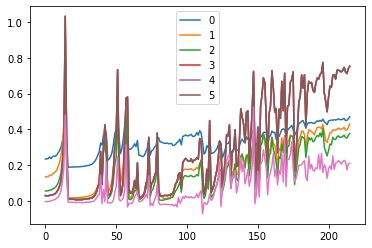

In [35]:
for l in model.act_means:
    plt.plot(l)
plt.legend(range(6))

What happens is that the mean of each layer gets exponentially bigger until they suddenly collapse, and again, and again, until eventually it starts training. It is true that it start training eventually, but there are many parameters in our model. Are we sure that, after "jumping off the cliff" they all go back to reasonable values? Maybe the majority of them has zero gradient now. We don't know.

The same thing happens for the standard deviations.

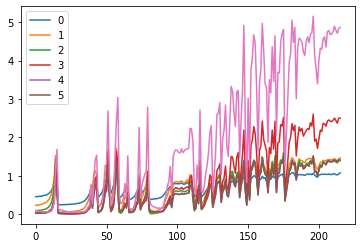

In [36]:
for l in model.act_stds:
    plt.plot(l)
plt.legend(range(6))

Let's look at the first 10 means. They look OK.

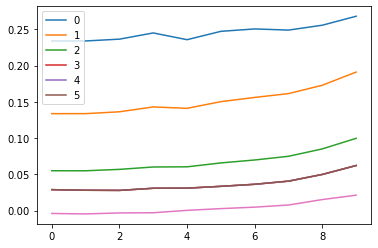

In [37]:
for l in model.act_means:
    plt.plot(l[:10])
plt.legend(range(6))

The standard deviations, however, do not look OK. The first one is, but the second layer has a lower std. dev, and the third one still lower, until the last layer has a std. dev. really close to zero. Looking at the means and the std. dev. we see that the final layers are moving to regions where there is no activation and no gradient. They were moving into regions where there is some gradient, but by the time they get there, the gradient is so fast, that they fall of a cliff and they have to start over again. This is what we want to fix, and we know that the right way to deal with this problem is with a good initialization.

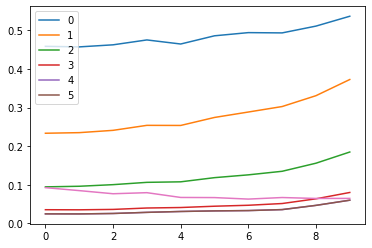

In [38]:
for l in model.act_stds:
    plt.plot(l[:10])
plt.legend(range(6))

### Pytorch hooks

Telemetry is clearly useful, but rewriting a `Sequential` class that can only monitor one small set of parameters is not a flexible approach. Here we cannot use callbacks because we don't have a callback that says "when you calculate this layer, call back to our code". We need to use a feature into PyTorch: *hooks*.

Hooks are PyTorch objects you can add to any nn.Module. A hook will be called when a layer, it is registered to, is executed during the forward pass (forward hook) or the backward pass (backward hook). They are very similar to callbacks in spirit.

Hooks don't require us to rewrite the model.

[Jump_to lesson 10 video](https://course.fast.ai/videos/?lesson=10&t=4693)

In [39]:
model = get_cnn_model(data, nfs)
learn, run = get_runner(model, data, lr=0.5, cbs=cbfs)

In order to reproduce the behaviour we saw in the previous section, we create two global variables to store the means and the std. devs for every layer.

In [40]:
act_means = [[] for _ in model]
act_stds = [[] for _ in model]

A hook is attached to a layer, and needs to have a function that takes three arguments: module, input, output. Here we store the mean and std of the output in the correct position of our list. This is the function we "call back to".

In [41]:
def append_stats(i, mod, inp, outp):
    act_means[i].append(outp.data.mean())
    act_stds[i].append(outp.data.std())

This is pretty much a callback that is called when the forward pass is executed. You can also call `register_backward_hook()` that will register a function that will be executed when the backward pass is called.

In [42]:
for i, m in enumerate(model):
    m.register_forward_hook(partial(append_stats, i))

In [43]:
run.fit(1, learn)

train: [1.588218125, tensor(0.4693, device='cuda:0')]
valid: [0.435075439453125, tensor(0.8747, device='cuda:0')]


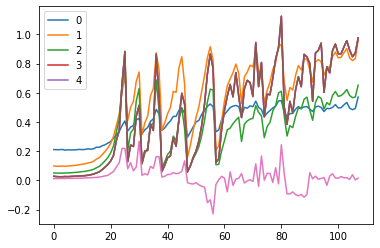

In [44]:
for o in act_means:
    plt.plot(o)
plt.legend(range(5))

### Hook class

Since hooks are so convenient, fastai has a `Hook` class. With this class we don't need to have the global variables any more, and the state can be stored inside the class.

It's very important to remove the hooks when they are deleted, otherwise there will be references kept and the memory won't be properly released when your model is deleted.

The `__del__()` method is called automatically when Python clears some memory, so when the code is done with the `Hook` instance, it will automatically call `self.remove()`, which in turn will remove the hook via `self.hook.remove()`.

[Jump_to lesson 10 video](https://course.fast.ai/videos/?lesson=10&t=4836)

In [45]:
#export
def children(m):
    return list(m.children())


class Hook():
    def __init__(self, m, f):  # `f` is the function to be registered
        self.hook = m.register_forward_hook(partial(f, self))

    def remove(self):
        self.hook.remove()

    def __del__(self):
        self.remove()

def append_stats(hook, mod, inp, outp):
    if not hasattr(hook, 'stats'):
        hook.stats = ([], [])
    means, stds = hook.stats
    means.append(outp.data.mean())
    stds.append(outp.data.std())

NB: In fastai we use a `bool` param to choose whether to make it a forward or backward hook. In the above version we're only supporting forward hooks.

In [46]:
model = get_cnn_model(data, nfs)
learn,run = get_runner(model, data, lr=0.5, cbs=cbfs)

The `[:4]` is because we want to look only at the convolutional layers.

In [47]:
hooks = [Hook(l, append_stats) for l in children(model[:4])]

In [48]:
run.fit(1, learn)

train: [1.7791925, tensor(0.3619, device='cuda:0')]
valid: [0.6464017578125, tensor(0.7944, device='cuda:0')]


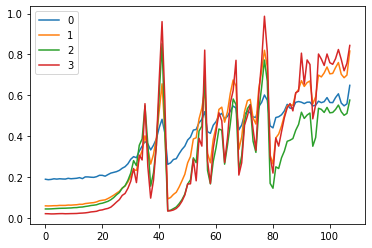

In [49]:
for h in hooks:
    plt.plot(h.stats[0])
    h.remove()
plt.legend(range(4));

### A Hooks class

Let's design our own class that can contain a list of objects. It will behave a bit like a numpy array in the sense that we can index into it via:
- a single index
- a slice (like 1:5)
- a list of indices
- a mask of indices (`[True,False,False,True,...]`)

The `__iter__` method is there to be able to do things like `for x in ...`.

[Jump_to lesson 10 video](https://course.fast.ai/videos/?lesson=10&t=4972)

In [50]:
#export
class ListContainer():
    def __init__(self, items):
        self.items = listify(items)

    def __getitem__(self, idx):
        if isinstance(idx, (int, slice)):
            return self.items[idx]
        if isinstance(idx[0], bool):
            assert len(idx) == len(self)  # bool mask
            return [o for m, o in zip(idx, self.items) if m]
        return [self.items[i] for i in idx]

    def __len__(self):
        return len(self.items)

    def __iter__(self):
        return iter(self.items)

    def __setitem__(self, i, o):
        self.items[i] = o

    def __delitem__(self, i):
        del(self.items[i])

    def __repr__(self):
        res = f'{self.__class__.__name__} ({len(self)} items)\n{self.items[:10]}'
        if len(self) > 10:
            res = res[:-1] + '...]'
        return res

In [51]:
ListContainer(range(10))

ListContainer (10 items)
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [52]:
ListContainer(range(100))

ListContainer (100 items)
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9...]

In [53]:
t = ListContainer(range(10))
t[[1,2]], t[[False]*8 + [True,False]]

([1, 2], [8])

We can use it to write a `Hooks` class that contains several hooks. We will also use it in the next notebook as a container for our objects in the data block API.

The `__del__()` method calls `self.remove()` that removes all the hooks in the list.
The fact that we can loop on `self` is because above we have defined a `ListContainer` which behaves somehow like a list, but also has some behaviors like NumPy. We can slice it since it has a `__getitem__()` but it can also take boolean indexing.

In [54]:
#export
from torch.nn import init


class Hooks(ListContainer):
    def __init__(self, ms, f):
        super().__init__([Hook(m, f) for m in ms])

    def __enter__(self, *args):
        return self

    def __exit__(self, *args):
        self.remove()

    def __del__(self):
        self.remove()

    def __delitem__(self, i):
        self[i].remove()
        super().__delitem__(i)

    def remove(self):
        for h in self:
            h.remove()

In [55]:
model = get_cnn_model(data, nfs).cuda()
learn,run = get_runner(model, data, lr=0.9, cbs=cbfs)

In [56]:
hooks = Hooks(model, append_stats)
hooks

Hooks (7 items)
[<__main__.Hook object at 0x7fa7d8f22b00>, <__main__.Hook object at 0x7fa7d8f22860>, <__main__.Hook object at 0x7fa7d8f17588>, <__main__.Hook object at 0x7fa7d8f17278>, <__main__.Hook object at 0x7fa7d8f282b0>, <__main__.Hook object at 0x7fa7d8f28eb8>, <__main__.Hook object at 0x7fa7d8f28e48>]

In [57]:
hooks.remove()

We can get a batch of data, resize it and send it to cuda.

In [58]:
x, y = next(iter(data.train_dl))
x = mnist_resize(x).cuda()

In [59]:
x.mean(), x.std()

(tensor(-0.0038, device='cuda:0'), tensor(0.9948, device='cuda:0'))

We can take the output of the first layer only and compute mean and std. dev.

In [60]:
p = model[0](x)
p.mean(), p.std()

(tensor(0.1930, device='cuda:0', grad_fn=<MeanBackward0>),
 tensor(0.3897, device='cuda:0', grad_fn=<StdBackward0>))

If we initialize with Kaiming's initialization, things are better.

In [61]:
for l in model:
    if isinstance(l, nn.Sequential):
        init.kaiming_normal_(l[0].weight)
        l[0].bias.data.zero_()

In [62]:
p = model[0](x)
p.mean(),p.std()

(tensor(0.5414, device='cuda:0', grad_fn=<MeanBackward0>),
 tensor(0.9571, device='cuda:0', grad_fn=<StdBackward0>))

Having given an `__enter__` and `__exit__` method to our `Hooks` class, we can use it as a context manager. This makes sure that onces we are out of the `with` block, all the hooks have been removed and aren't there to pollute our memory.

Here we first plot the first 10 means and std. devs, and then we plot them all.

train: [1.906009375, tensor(0.3469, device='cuda:0')]
valid: [1.0544478515625, tensor(0.6520, device='cuda:0')]
train: [0.4554446484375, tensor(0.8612, device='cuda:0')]
valid: [0.17144447021484374, tensor(0.9475, device='cuda:0')]


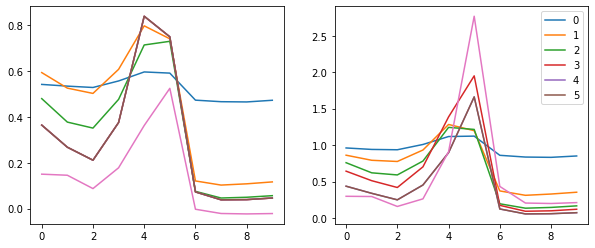

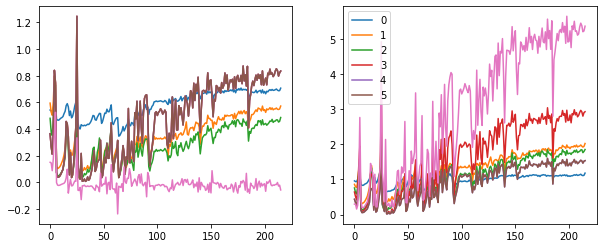

In [63]:
with Hooks(model, append_stats) as hooks:
    run.fit(2, learn)
    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 4))
    for h in hooks:
        ms, ss = h.stats
        ax0.plot(ms[:10])
        ax1.plot(ss[:10])
    plt.legend(range(6))

    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 4))
    for h in hooks:
        ms, ss = h.stats
        ax0.plot(ms)
        ax1.plot(ss)
    plt.legend(range(6))

### Other statistics

Our initial quesition was about how many of the activations are really small, and how harmful is the "cliffy" behavior we saw initially.

Let's store more than the means and stds and plot histograms of our activations now.

[Jump_to lesson 10 video](https://course.fast.ai/videos/?lesson=10&t=5233)

In [64]:
def append_stats(hook, mod, inp, outp):
    if not hasattr(hook, 'stats'):
        hook.stats = ([], [], [])
    means, stds, hists = hook.stats
    means.append(outp.data.mean().cpu())
    stds .append(outp.data.std().cpu())
    # histc isn't implemented on the GPU
    hists.append(outp.data.cpu().histc(40, 0, 10))

Note that we are setting a really large learning rate.

In [65]:
model = get_cnn_model(data, nfs).cuda()
learn, run = get_runner(model, data, lr=0.9, cbs=cbfs)

In [66]:
for l in model:
    if isinstance(l, nn.Sequential):
        init.kaiming_normal_(l[0].weight)
        l[0].bias.data.zero_()

In [67]:
with Hooks(model, append_stats) as hooks:
    run.fit(1, learn)

train: [1.87542359375, tensor(0.3436, device='cuda:0')]
valid: [0.61994619140625, tensor(0.8165, device='cuda:0')]


In [68]:
# Thanks to @ste for initial version of histgram plotting code
def get_hist(h):
    return torch.stack(h.stats[2]).t().float().log1p()

[Jump_to lesson 10 video](https://course.fast.ai/videos/?lesson=10&t=5582)

Here we see that even with the large learning rate we set, we have this spikey trend. The real concern, however, is the yellow line at the bottom. That's where most of the histogram concentrates. Here the `x` axis is the iteration, while the `y` axis is the activation level. The counts are shown by the color density.

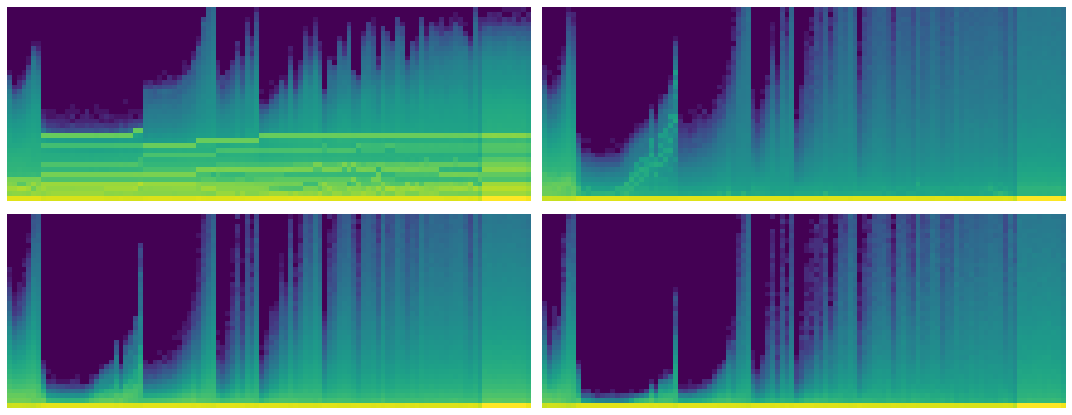

In [69]:
fig, axes = plt.subplots(2, 2, figsize=(15, 6))
for ax, h in zip(axes.flatten(), hooks[:4]):
    ax.imshow(get_hist(h), origin='lower')
    ax.axis('off')
plt.tight_layout()

From the histograms, we can easily get more informations like the min or max of the activations. We take the sum of the content of the first two bins, and we divide it by the sum of all of the bins. This will tell us what percentage of the activations is zero or nearly zero.

In [70]:
def get_min(h):
    h1 = torch.stack(h.stats[2]).t().float()
    return h1[:2].sum(0)/h1.sum(0)

In the last layer, almost 90% of the activations are near zero.

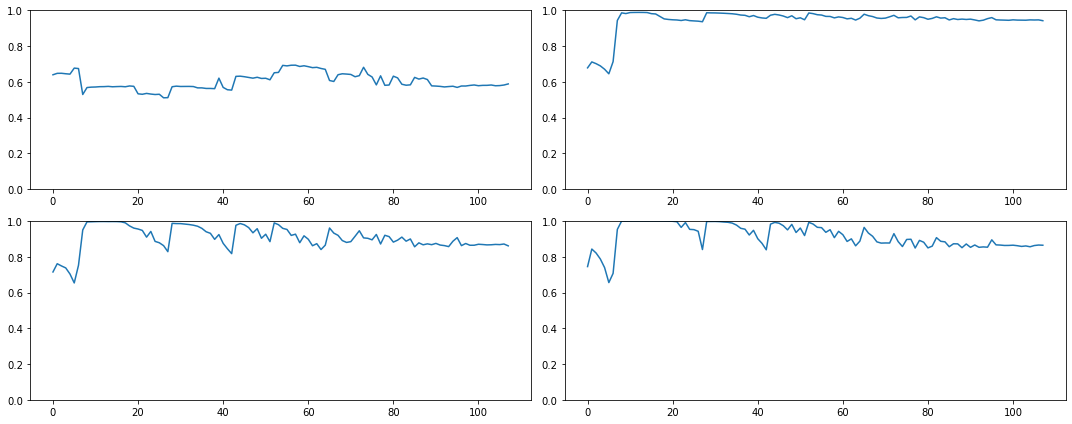

In [71]:
fig, axes = plt.subplots(2, 2, figsize=(15, 6))
for ax, h in zip(axes.flatten(), hooks[:4]):
    ax.plot(get_min(h))
    ax.set_ylim(0, 1)
plt.tight_layout()

## Generalized ReLU

With the previous setting, we are throwing away 90% of the activations. Let's try to fix this. We are going to try a few things, but first fo all we will use our model with a generalized ReLU that can be shifted and with maximum value.

We can subtract an amount `sub` from the ReLU, as we saw that subtracting 0.5 seemed to be beneficial. We can have leakage, and we can also add a maximum value to clamp. We pass this `GeneralRelu` to the function that generates the `Sequential` model.

[Jump_to lesson 10 video](https://course.fast.ai/videos/?lesson=10&t=5390)

In [72]:
#export
def get_cnn_layers(data, nfs, layer, **kwargs):
    nfs = [1] + nfs
    return [layer(nfs[i], nfs[i+1], 5 if i == 0 else 3, **kwargs)
            for i in range(len(nfs)-1)] + [
        nn.AdaptiveAvgPool2d(1), Lambda(flatten), nn.Linear(nfs[-1], data.c)]


def conv_layer(ni, nf, ks=3, stride=2, **kwargs):
    return nn.Sequential(
        nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride), GeneralRelu(**kwargs))


class GeneralRelu(nn.Module):
    def __init__(self, leak=None, sub=None, maxv=None):
        super().__init__()
        self.leak = leak
        self.sub = sub
        self.maxv = maxv 

    def forward(self, x):
        x = F.leaky_relu(x, self.leak) if self.leak is not None else F.relu(x)
        if self.sub is not None:
            x.sub_(self.sub)
        if self.maxv is not None:
            x.clamp_max_(self.maxv)
        return x


def init_cnn(m, uniform=False):
    f = init.kaiming_uniform_ if uniform else init.kaiming_normal_
    for l in m:
        if isinstance(l, nn.Sequential):
            f(l[0].weight, a=0.1)
            l[0].bias.data.zero_()


def get_cnn_model(data, nfs, layer, **kwargs):
    return nn.Sequential(*get_cnn_layers(data, nfs, layer, **kwargs))

We need to change the limits of the histograms, since the new ReLU now allows negative values. We also need to change the definition of `get_min` below.

In [73]:
def append_stats(hook, mod, inp, outp):
    if not hasattr(hook, 'stats'):
        hook.stats = ([], [], [])
    means, stds, hists = hook.stats
    means.append(outp.data.mean().cpu())
    stds.append(outp.data.std().cpu())
    hists.append(outp.data.cpu().histc(40, -7, 7))

Note that we subtract 0.4, not 0.5, because the leaky ReLU compensates for it, somehow.

In [74]:
model = get_cnn_model(data, nfs, conv_layer, leak=0.1, sub=0.4, maxv=6.)
init_cnn(model)
learn, run = get_runner(model, data, lr=0.9, cbs=cbfs)

train: [0.5504025390625, tensor(0.8259, device='cuda:0')]
valid: [0.163571533203125, tensor(0.9538, device='cuda:0')]


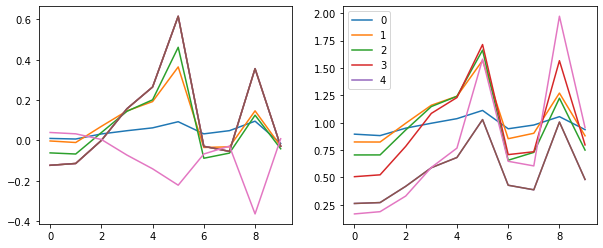

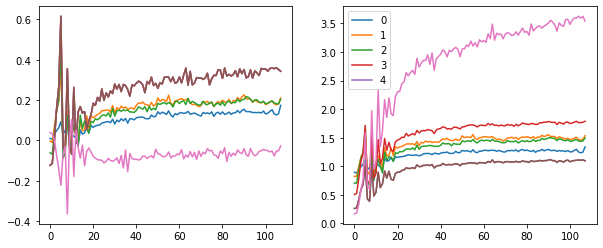

In [75]:
with Hooks(model, append_stats) as hooks:
    run.fit(1, learn)
    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 4))
    for h in hooks:
        ms, ss, hi = h.stats
        ax0.plot(ms[:10])
        ax1.plot(ss[:10])
        h.remove()
    plt.legend(range(5))

    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 4))
    for h in hooks:
        ms, ss, hi = h.stats
        ax0.plot(ms)
        ax1.plot(ss)
    plt.legend(range(5))

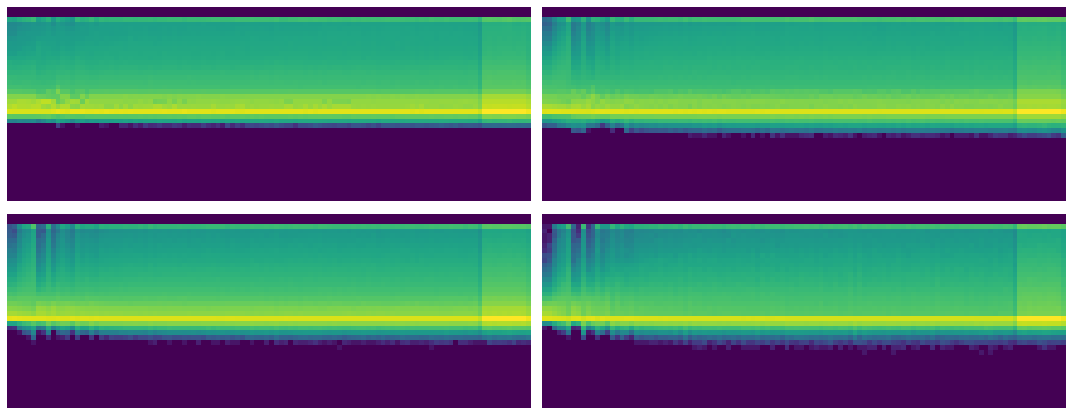

In [76]:
fig, axes = plt.subplots(2, 2, figsize=(15, 6))
for ax, h in zip(axes.flatten(), hooks[:4]):
    ax.imshow(get_hist(h), origin='lower')
    ax.axis('off')
plt.tight_layout()

In [77]:
def get_min(h):
    h1 = torch.stack(h.stats[2]).t().float()
    return h1[19:22].sum(0)/h1.sum(0)

This looks much better. How many dead activations do we now have in the final layers? Less than 20%.

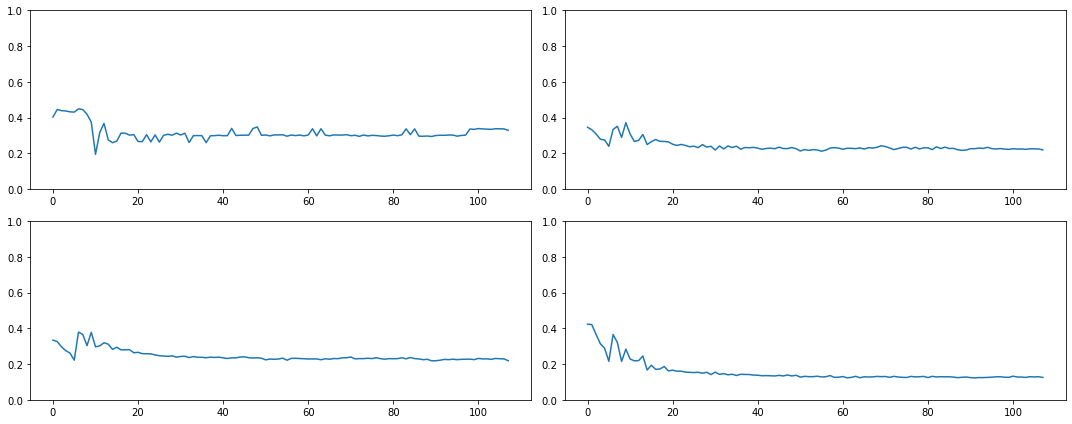

In [78]:
fig, axes = plt.subplots(2, 2, figsize=(15, 6))
for ax, h in zip(axes.flatten(), hooks[:4]):
    ax.plot(get_min(h))
    ax.set_ylim(0, 1)
plt.tight_layout()

[Jump_to lesson 10 video](https://course.fast.ai/videos/?lesson=10&t=5705)

In [79]:
#export
def get_learn_run(nfs, data, lr, layer, cbs=None, opt_func=None, uniform=False, **kwargs):
    model = get_cnn_model(data, nfs, layer, **kwargs)
    init_cnn(model, uniform=uniform)
    return get_runner(model, data, lr=lr, cbs=cbs, opt_func=opt_func)

The above looks good. What do we get if we train with a 1-cycle learning where we use what we previously build?

In [80]:
sched = combine_scheds([0.5, 0.5], [sched_cos(0.2, 1.), sched_cos(1., 0.1)]) 

In [81]:
learn,run = get_learn_run(nfs, data, 1., conv_layer, cbs=cbfs+[partial(ParamScheduler,'lr', sched)])

In [82]:
run.fit(8, learn)

train: [1.175457890625, tensor(0.6284, device='cuda:0')]
valid: [0.2924742919921875, tensor(0.9113, device='cuda:0')]
train: [0.29882041015625, tensor(0.9096, device='cuda:0')]
valid: [0.2261158935546875, tensor(0.9333, device='cuda:0')]
train: [0.229973203125, tensor(0.9309, device='cuda:0')]
valid: [0.13425537109375, tensor(0.9611, device='cuda:0')]
train: [0.24094763671875, tensor(0.9286, device='cuda:0')]
valid: [0.09381641235351562, tensor(0.9729, device='cuda:0')]
train: [0.0890846484375, tensor(0.9721, device='cuda:0')]
valid: [0.07011843872070313, tensor(0.9781, device='cuda:0')]
train: [0.06235158203125, tensor(0.9803, device='cuda:0')]
valid: [0.0670060791015625, tensor(0.9798, device='cuda:0')]
train: [0.046255478515625, tensor(0.9850, device='cuda:0')]
valid: [0.062286871337890626, tensor(0.9812, device='cuda:0')]
train: [0.03805746826171875, tensor(0.9885, device='cuda:0')]
valid: [0.06210128784179687, tensor(0.9817, device='cuda:0')]


We get to ~98%!

**Homework** beat this performance!

If you look at the definition of `init_cnn` there is a `uniform=False` argument. If set to `True`, it uses the Kaiming *uniform* initialization, instead of the Kaiming *normal* one.

Uniform init may provide more useful initial weights (normal distribution puts a lot of them at 0).

In [83]:
learn,run = get_learn_run(nfs, data, 1., conv_layer, uniform=True,
                          cbs=cbfs+[partial(ParamScheduler,'lr', sched)])

In [84]:
run.fit(8, learn)

train: [1.234180859375, tensor(0.6126, device='cuda:0')]
valid: [0.300151220703125, tensor(0.9072, device='cuda:0')]
train: [0.30423412109375, tensor(0.9067, device='cuda:0')]
valid: [0.1755846435546875, tensor(0.9471, device='cuda:0')]
train: [0.5286682421875, tensor(0.8340, device='cuda:0')]
valid: [1.8083259765625, tensor(0.3535, device='cuda:0')]
train: [1.135832890625, tensor(0.6311, device='cuda:0')]
valid: [0.440197021484375, tensor(0.8804, device='cuda:0')]
train: [0.2072702734375, tensor(0.9365, device='cuda:0')]
valid: [0.1186324951171875, tensor(0.9627, device='cuda:0')]
train: [0.102763427734375, tensor(0.9678, device='cuda:0')]
valid: [0.091972607421875, tensor(0.9717, device='cuda:0')]
train: [0.076675166015625, tensor(0.9763, device='cuda:0')]
valid: [0.0804925048828125, tensor(0.9766, device='cuda:0')]
train: [0.0651065380859375, tensor(0.9794, device='cuda:0')]
valid: [0.07786752319335938, tensor(0.9768, device='cuda:0')]


## Export

Here's a handy way to export our module without needing to update the file name - after we define this, we can just use `nb_auto_export()` in the future (h/t Stas Bekman):

In [85]:
#export
from IPython.display import display, Javascript
def nb_auto_export():
    display(Javascript("""{
const ip = IPython.notebook
if (ip) {
    ip.save_notebook()
    console.log('a')
    const s = `!python notebook2script.py ${ip.notebook_name}`
    if (ip.kernel) { ip.kernel.execute(s) }
}
}"""))

In [86]:
nb_auto_export()

<IPython.core.display.Javascript object>